# main figure generation scripts

# setup environment and relative paths to data, define helper functions

In [ ]:
import pickle, pandas, os, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import warnings; warnings.filterwarnings('ignore')
from scipy import stats

In [ ]:
def estimate_reliability(df, X='correct', sort_by='trial', n_iterations=1000):
  """
  df contains columns 'correct' and sorts by sort_by
  """
  split_half_reliability = []

  null = []

  for i_iteration in range(n_iterations):

    X1, X2, y1, y2 = train_test_split(df[X],df[sort_by],
                                      test_size=0.5,
                                      stratify=df[sort_by])

    split1 = pandas.DataFrame({'X': X1, 'y': y1}).groupby('y').mean().X
    split2 = pandas.DataFrame({'X': X2, 'y': y2}).groupby('y').mean().X

    split_half_reliability.append( np.corrcoef( split1, split2)[0, 1] )
    null.append( np.corrcoef( split1, np.random.permutation(split2))[0, 1])

  return split_half_reliability, null

def extract_list(l):
  return [i[1:-1] for i in l[1:-1].split(', ')]

In [ ]:
from google.colab import drive ; drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
base_dir = './gdrive/MyDrive/neurips_benchmark/for_reviewers'
image_dir = os.path.join(base_dir, 'images')
data_dir = os.path.join(base_dir, 'data')

In [ ]:
save_figures = False
if save_figures:
  figure_save_location = os.path.join(base_dir, 'figures')
else:
  figure_save_location = None

# load data

## load main analysis file (human + model data) from 'benchmark.csv'

In [ ]:
df = pandas.read_csv(os.path.join(data_dir, 'benchmark.csv'))

## load model performance estimated using distance measures

In [ ]:
df_distance = pandas.read_csv(os.path.join(data_dir, 'df_behavior_wdistance.csv'))

## load human behavioral data necessary to estimate reliability

In [ ]:
df_subject = pandas.read_csv(os.path.join(data_dir, 'df_behavior_subjects.csv'))

## load attention maps from dinov2

In [ ]:
with open(os.path.join(data_dir, 'splithalf_dinov2_vitg14.pkl'), 'rb') as f:
    split_half_gaze = pickle.load(f)

## load salience maps from human experiments

In [ ]:
with open(os.path.join(data_dir, 'salience_maps.pickle'), 'rb') as handle:
    salience_maps_pkl = pickle.load(handle)

## load parameter/FLOP data for each model

In [ ]:
with open(os.path.join(data_dir, 'model_params_count.pkl'), 'rb') as f:
    model_params = pickle.load(f)

# estimate reliability of human behavior for each dataset and across benchmark

In [ ]:
print('n_trials:', len(df_subject),
      'n_image sets:', df_subject.trial.nunique(),
      'n_subjects:', df_subject.subject_id.nunique())
# doesn't include subjects in eyetracking studies (~100)

n_trials: 35445 n_image sets: 2046 n_subjects: 485


In [ ]:
reliabilities = {}
nulls = {}

for d in ['barense', 'hvm', 'shapegen', 'shapenet']:

  df_subset = df_subject[df_subject.dataset==d]
  reliabilities[d], nulls[d]  = estimate_reliability(df_subset)

reliabilities['all'], nulls['all']  = estimate_reliability(df_subject)
reliabilities['all_rt'], nulls['all_rt'] = estimate_reliability(df_subject, X='rt')

# visualize human data

## define colormap for each dataset in benchmark

In [ ]:
n_colors = 4
colormap = mpl.colormaps['cool'](np.linspace(0, 1, n_colors))
colors = {
    'barense': colormap[0],
    'hvm':     colormap[1],
    'shapegen':colormap[2],
    'shapenet':colormap[3],
    }

## plot histogram of human performance across trials in each dataset

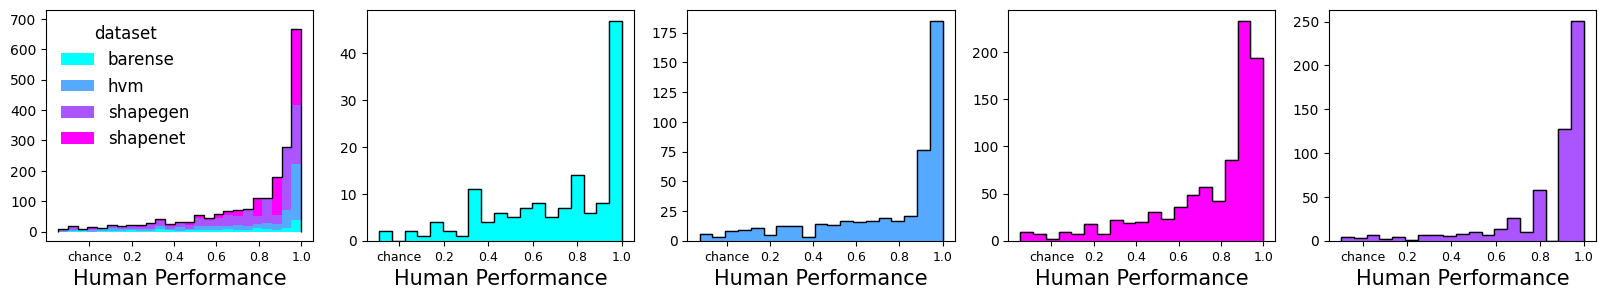

In [ ]:
def show_hists(df, color, label):

  _ax = plt.hist(df['human_accuracy'], edgecolor=color, bins=19, color=color, label=label)
  plt.hist(df['human_accuracy'], bins=19, histtype='step', color='black')
  plt.xlabel("Human Performance", fontsize=15)
  plt.xticks([0, .2, .4, .6, .8, 1.], ['chance', .2, .4, .6, .8, 1.], fontsize=9)


plt.figure(figsize = (20, 3))
plt.subplot(151)
_ax = plt.hist([df[df.dataset==d].human_accuracy.values for d in df.dataset.unique()],
         stacked=True, color=[colors[i] for i in colors], bins=25)
plt.legend([c for c in colors], frameon=0, title='dataset', fontsize=12, title_fontsize=12)
plt.xticks([0, .2, .4, .6, .8, 1.], ['chance', .2, .4, .6, .8, 1.], fontsize=9)
plt.xlabel('Human Performance', fontsize=15)
plt.ylim(-30, 730)
plt.hist(df.human_accuracy.values, color='black', histtype='step', bins=25)
ymin, ymax = -.22, 1.05
bins = 20
for index, dataset in enumerate(df.dataset.unique()):
  plt.subplot(1, 5, index+2)
  _ax = show_hists(df[df.dataset==dataset], color=colors[dataset], label=dataset)

if figure_save_location:
  path = os.path.join(figure_save_location, 'human_histograms_across_datasets.pdf')
  plt.savefig(path, bbox_inches='tight');

## barplots with accuracy for each condition in benchmark

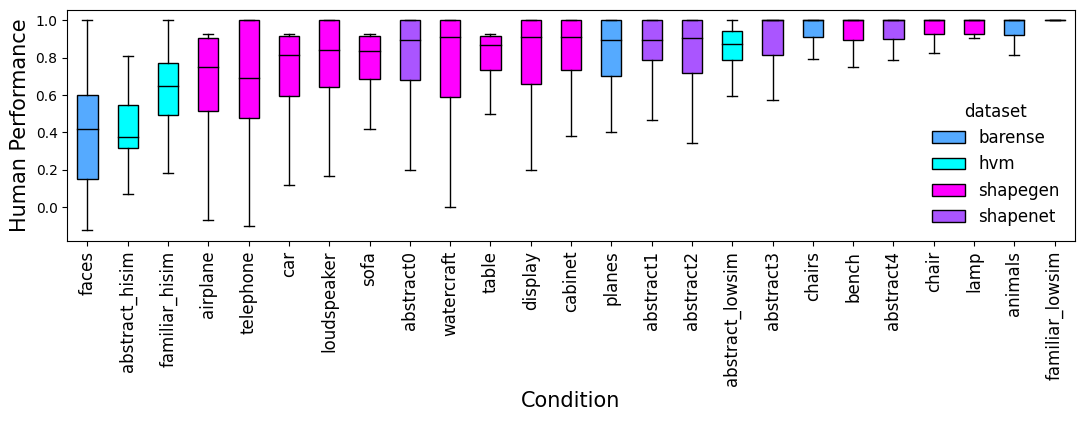

In [ ]:
c_sorted = df.groupby('condition', as_index=False).human_accuracy.mean().sort_values('human_accuracy')['condition']

_data = []
_color = []
_label = []

for c in c_sorted:
  _data.append(df[df.condition==c].human_accuracy.values)
  _color.append(colors[df[df.condition==c].dataset.values[0]])
  _label.append(c)

plt.figure(figsize=[13, 3])

bplot = plt.boxplot(_data, patch_artist=True, showfliers=False);
plt.xticks(range(1, len(_label)+1), _label, rotation=90, fontsize=12)

# fill with colors
for patch, c in zip(bplot['boxes'], _color):
    patch.set_facecolor(c)
plt.ylabel('Human Performance', fontsize=15)
plt.xlabel('Condition', fontsize=15)

for median in bplot['medians']:
    median.set_color('black')

plt.legend([bplot["boxes"][i] for i in [0, 1, 3, 8]],
           list(colors), frameon=0,
           title='dataset',
           #loc='upper right',
           loc=4, #bbox_to_anchor=[1.15, 1],
           fontsize=12, title_fontsize=12);

if figure_save_location:
  path = os.path.join(figure_save_location, 'human_boxplots_across_conditions.pdf')
  plt.savefig(path, bbox_inches='tight');

## scatterplots with accuracy and reaction time distributions for each dataset

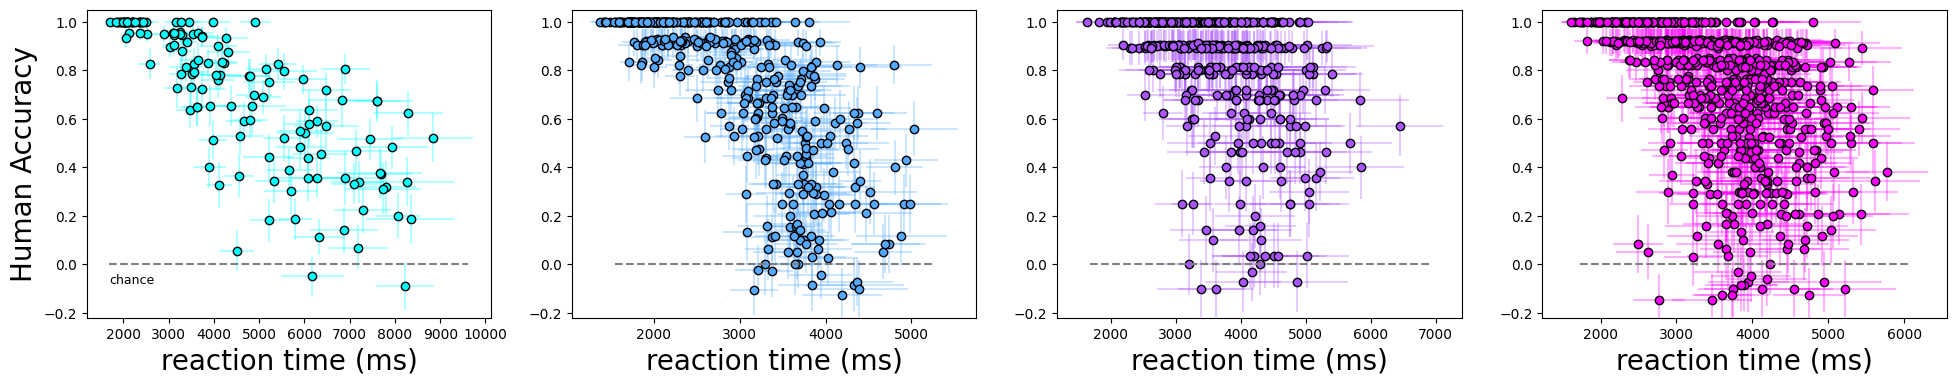

In [ ]:
def show_data(df, color, label):
  plt.errorbar(y = df['human_accuracy'], x = df['human_rt'],
              xerr = df['human_rt_sem'], yerr = df['human_accuracy_sem'],
              ls='none', c=color, zorder=-5, alpha=.3)

  _ax = plt.scatter(y = df['human_accuracy'], x = df['human_rt'],
              edgecolor='black', color=color)

  xmin, xmax = _ax.axes.get_xlim()[0] + 500, _ax.axes.get_xlim()[1] - 500
  plt.plot((xmin, xmax), (0,0), linestyle='--', color='grey')

  return _ax

ymin, ymax = -.22, 1.05

plt.figure(figsize = (24, 4))

plt.subplot(141)
plt.ylabel('Human Accuracy', fontsize=20)
plt.ylim(ymin, ymax)
show_data(df[df.dataset=='barense'], color=colors['barense'], label='')
plt.xlabel('reaction time (ms)', fontsize=20)
plt.ylim(ymin, ymax)
plt.annotate('chance', (1700, -.08), fontsize=9)

plt.subplot(142)
show_data(df[df.dataset=='hvm'], color=colors['hvm'], label='')
plt.xlabel('reaction time (ms)', fontsize=20)
plt.ylim(ymin, ymax)

plt.subplot(143)
show_data(df[df.dataset=='shapegen'], color=colors['shapegen'], label='')
plt.xlabel('reaction time (ms)', fontsize=20)
plt.ylim(ymin, ymax)

plt.subplot(144)
_ax = show_data(df[df.dataset=='shapenet'], color=colors['shapenet'], label='')
plt.xlabel('reaction time (ms)', fontsize=20)
plt.ylim(ymin, ymax)

if figure_save_location:
  path = os.path.join(figure_save_location,  'human_scatterplot_across_datasets.pdf')
  plt.savefig(path, bbox_inches='tight')

## histograms with split-half reliability of human behavior in each dataset

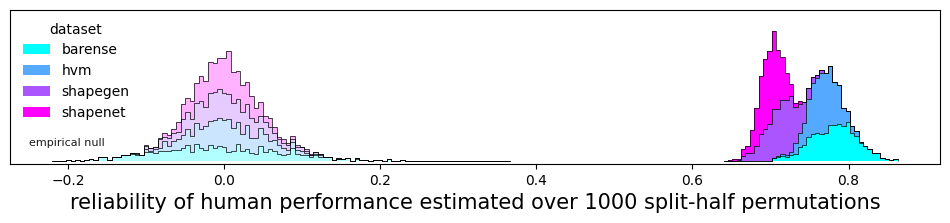

In [ ]:
plt.figure(figsize = (12, 2))

show_reliabilities = [i for i in reliabilities if 'all' not in i]

plt.hist([reliabilities[d] for d in show_reliabilities], stacked=True, bins=40,
         label=[d for d in colors],
         color=[colors[i] for i in colors])

plt.hist([reliabilities[d] for d in show_reliabilities], bins=40, histtype='step',
          stacked=True, color=['black' for i in colors], linewidth=.5)

hsts = plt.hist([nulls[d] for d in show_reliabilities], stacked=True, histtype='step',
         color=['black' for i in colors], bins=100, linewidth=.5)

plt.hist([nulls[d] for d in show_reliabilities], bins=100, stacked=True,
         color=[colors[i] for i in colors], alpha=.3)

plt.xlabel('reliability of human performance estimated over 1000 split-half permutations', fontsize=15)
plt.annotate('empirical null', (-.25, 30), alpha=.9, fontsize=8)
legend1 = plt.legend(frameon=False, loc=2, title='dataset');
plt.ylim(-5, 300)
plt.yticks([],[]);
if figure_save_location:
  print('!')
  path = os.path.join(figure_save_location, 'human_histogram_reliability.pdf')
  plt.savefig(path, bbox_inches='tight')

## visualize random subset of human attention maps

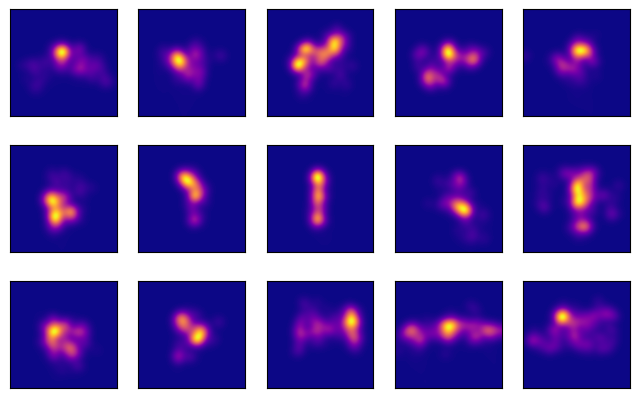

In [ ]:
np.random.seed(23)
plt.figure(figsize=[8, 5])

for i_plot in range(15):
  plt.subplot(3,5,i_plot+1)
  images = list( salience_maps_pkl['population'] )
  rand_ind = np.random.randint(len(images))
  rand_image = images[rand_ind]
  plt.imshow( salience_maps_pkl['population'][rand_image], cmap='plasma');
  plt.xticks([], [])
  plt.yticks([], [])

if figure_save_location:
  path = os.path.join(figure_save_location, 'random_salience_maps.pdf')
  plt.savefig(path, bbox_inches='tight');

# visualize human-model data

## determine which models to visualize and how to label them

In [ ]:
bars = ['human_accuracy',
        'dinov2-giant_svm_avg',
        'dinov2-large_svm_avg',
        'dinov2-base_svm_avg',
        'CLIP_ViT-g-14_svm_avg',
        'CLIP_ViT-H-14_svm_avg',
        'CLIP_ViT-L-14_svm_avg',
        'vit-mae-huge_svm_avg',
        'vit-mae-large_svm_avg',
        'vit-mae-base_svm_avg']

bar_order = ['human_accuracy',
        'dinov2-giant_svm_avg',
        'dinov2-large_svm_avg',
        'dinov2-base_svm_avg',
        'CLIP_ViT-g-14_svm_avg',
        'CLIP_ViT-H-14_svm_avg',
        'CLIP_ViT-L-14_svm_avg',
        'vit-mae-huge_svm_avg',
        'vit-mae-large_svm_avg',
        'vit-mae-base_svm_avg',]

namekey = {'human_accuracy': 'HUMAN',
 'dinov2-giant_svm_avg': 'DINOv2-G',
 'dinov2-large_svm_avg': 'DINOv2-L',
 'dinov2-base_svm_avg': 'DINOv2-B',
 'dino_distance_avg': 'DINOv2-B-cos',
 'CLIP_ViT-L-14_svm_avg': 'CLIP-L-14',
 'CLIP_ViT-H-14_svm_avg': 'CLIP-H-14',
 'CLIP_ViT-g-14_svm_avg': 'CLIP-G-14',
 'CLIP_ViT-B-16_svm_avg': 'CLIP-B-16',
 'CLIP_ViT-B-32_svm_avg': 'CLIP-B-32',
 'vit-mae-base_svm_avg': 'MAE-B',
 'vit-mae-large_svm_avg': 'MAE-L',
 'vit-mae-huge_svm_avg': 'MAE-H'}

## plot model performance in terms of FLOPS, scale points by model size

renaming CLIP models


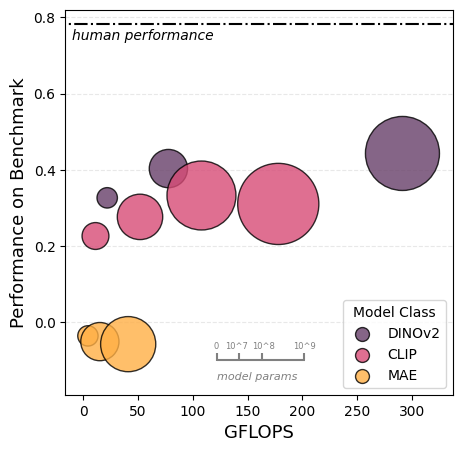

In [ ]:
if not sum(['CLIP' in i for i in list(model_params['n_params'])]):

  print('renaming CLIP models')
  n_params = model_params['n_params']
  flops = model_params['flops']

  for m in list(n_params):
    if 'ViT' in m:
      n_params['CLIP_' + m] = n_params.pop(m)
      flops['CLIP_' + m] = flops.pop(m)

  compare_models = [i for i in n_params if i != 'CLIP_ViT-B-32']


MODEL_COLORS = {
    'DINOv2': '#673F69',
    'CLIP':     '#D74B76',
    'MAE': '#FFAF45',
    }

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
ax.yaxis.grid(color='lightgrey', linestyle='--', alpha=.5, zorder=-1)
ax.grid(which='major', axis='y', zorder=-1)

scale_point  = 400000
all_ss = []
all_params = []
gflop = 1e9
for i_set in ['DINOv2', 'CLIP', 'MAE']:

  i_models = [m for m in compare_models if i_set.lower() in m.lower()]
  s = np.array([n_params[m] for m in i_models])//scale_point
  params = [n_params[m] for m in i_models]
  x = [flops[m][0]/gflop for m in i_models]
  y = [df[m + '_svm_avg'].mean() for m in i_models],
  ax.scatter(x = [flops[m][0]/gflop for m in i_models],
             y = [df[m + '_svm_avg'].mean() for m in i_models],
             alpha=.8, s=s, zorder=10, label=i_set, color=MODEL_COLORS[i_set],
             edgecolor='black', linewidth=1)


  all_ss.extend(s)
  all_params.extend(params)
  axes2 = plt.gca()

xmin = axes2.get_xlim()[0]
xmax = axes2.get_xlim()[1]

plt.ylim(-.19, .82 )
xshift = .02 * (axes2.get_xlim()[1] - axes2.get_xlim()[0])
plt.xlim(xmin - xshift,xmax + xshift*5)

lgnd = plt.legend(title='Model Class')
for i in range(len(lgnd.legendHandles)):
  lgnd.legendHandles[i]._sizes = [100]

plt.xlabel('GFLOPS', fontsize=13)
plt.ylabel('Performance on Benchmark', fontsize=13)

adjust_edgeby  = 10000
h_avg = df['human_accuracy'].mean ()
plt.plot([xmin + adjust_edgeby, xmax - adjust_edgeby],[h_avg, h_avg],
         color='black', linestyle='-.')
plt.annotate('human performance', (xmin , h_avg-.04), fontsize=10,
             fontstyle='italic')

# Function to calculate the diameter of a point
def calc_diameter(s):
    return 2 * np.sqrt(s / np.pi)

calc_diameter(s)[0]

IND = 2
# biggest
length_max = (calc_diameter(np.max( all_ss ) ) * (pow(10, 9.08) /gflop ) )
# middle
length_mid = (calc_diameter(np.median( all_ss ) ) * (pow(10, 9.08) /gflop ) )
# min
length_min = (calc_diameter(np.min( all_ss ) ) * (pow(10, 9.08) /gflop ) )

xstart = xmax/2.5 #x[IND]  - (length/2)
xend = xstart + length_max
ylevel = -.1
yadjust = .02
plt.hlines(ylevel, xstart, xend + pow(10, 9)/gflop, color='grey', linestyle='-')
plt.vlines(xstart, ymax=ylevel+yadjust, ymin=ylevel-.002 , color='grey',linestyle='-')
plt.annotate('0', (xstart - pow(10, 9.47)/gflop, ylevel+yadjust+.01),
            fontsize=6,  color='grey')

plt.vlines(xend, ymax=ylevel+yadjust, ymin=ylevel , color='grey', linestyle='-')
plt.annotate('10^%d'%np.log10(np.max(all_params)),
             (xend - pow(10, 10)/gflop, ylevel+yadjust+.01), fontsize=6, color='grey')

xend = xstart + length_mid
plt.vlines(xend, ymax=ylevel+yadjust, ymin=ylevel , color='grey', linestyle='-')
plt.annotate('10^%d'%np.log10(np.sort(all_params)[len(all_params)//2]) ,
            (xend - pow(10, 9.95)/gflop, ylevel+yadjust+.01), fontsize=6,
              color='grey')

xend = xstart + length_min
plt.vlines(xend, ymax=ylevel+yadjust, ymin=ylevel , color='grey', linestyle='-')
plt.annotate('10^%d'%np.log10(np.min(all_params)),
            (xend - pow(10, 10.11)/gflop, ylevel+yadjust+.01), fontsize=6,
              color='grey')

plt.annotate('model params', (xstart, ylevel-.05),
             fontsize=8,  fontstyle='italic', color='grey')

if figure_save_location:
  path = os.path.join(figure_save_location, 'nparams_flops_performance.pdf')
  plt.savefig(path, bbox_inches='tight');

## barplots to compare human accuracy on each dataset to model performance

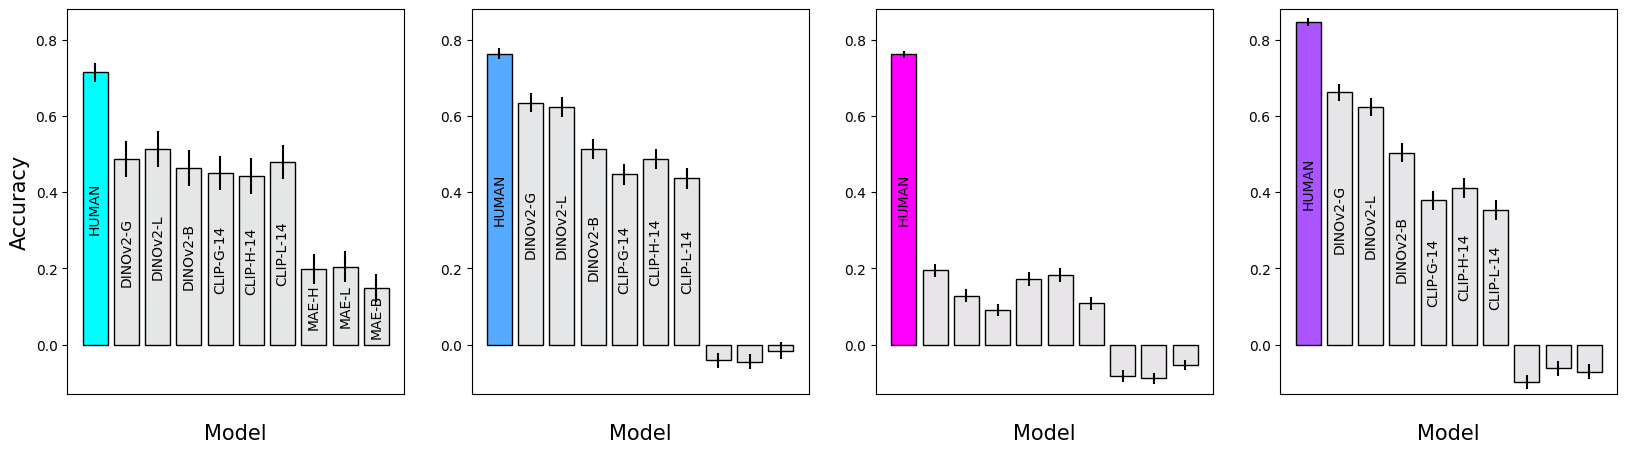

In [ ]:
plt.figure(figsize=[20,5])

for iplot, d in enumerate(df.dataset.unique()):

  plt.subplot(1,4,iplot+1)

  pltbar = plt.bar(bar_order, df[df.dataset==d][bar_order].mean() ,
                   color=[[colors[d]* (.1, .1, .1, .1),
                           colors[d]]['human' in i] for i in bar_order],
                   edgecolor='black', label=[namekey[i] for i in bar_order],
                   )
  if iplot ==0:
    ABV = .10
    plt.ylabel('Accuracy', fontsize=15)

    # plt.bar_label(pltbar, [namekey[i] for i in bar_order],
    #               label_type='center', color='black', rotation=90)

  else:
    ABV = .20

  plt.bar_label(
          pltbar,
           [[namekey[bars[i]], ''][pltbar[i].get_height()<ABV] for i in range(len(bars))],
          label_type='center',color='black', rotation=90)

  plt.errorbar(bar_order, df[df.dataset==d][bar_order].mean(),
               yerr=df[df.dataset==d][bar_order].sem(),
               ls='', color='black')
  plt.xticks([], []);
  plt.ylim(-.13, .88)
  plt.xlabel("\nModel", fontsize=15)

if figure_save_location:
  path = os.path.join(figure_save_location, 'human_and_model_boxplots_across_datasets.pdf')
  plt.savefig(path, bbox_inches='tight');

## show relationship between human reaction time and model performance in each dataset

In [ ]:
def sort_trials(idf, n_groups=20, groupby='human_accuracy'):
  """bin trials according to either human or model performance"""
  def nonzero(x):
    return np.nonzero(x)[0][0]
  sorted = idf.sort_values(groupby).index
  len_sorted = len(sorted)
  _size = len(sorted)//n_groups
  _range = range(len_sorted//_size + 1)
  _markers = np.array([[j for i in range(_size)] for j in _range]).flatten()
  _markers = _markers[:len(idf)]
  trial_group = [_markers[nonzero(i == sorted)] for i in idf.index.values]
  return trial_group

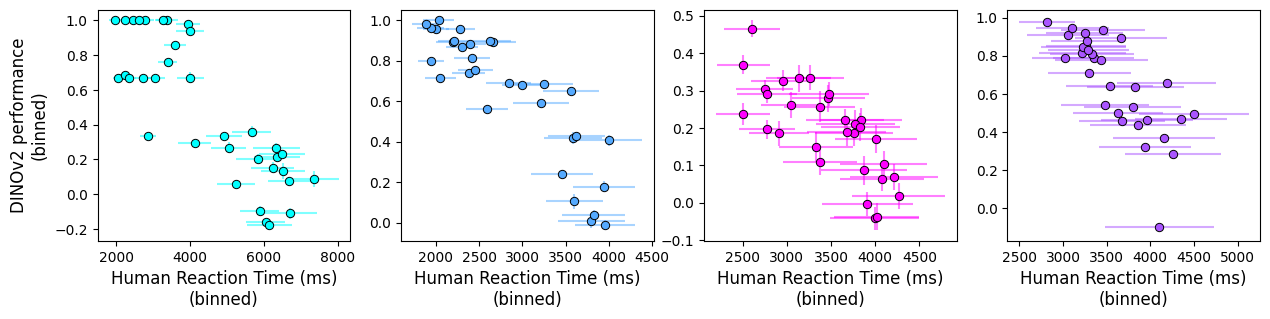

In [ ]:
model_names = {'dino': 'dinov2-giant','clip': 'CLIP_ViT-g'}

model_name = model_names['dino'] # 'dinov2-giant_svm_avg'

plt.figure(figsize=[15,3])

for iplot, d in enumerate(df.dataset.unique()):

  plt.subplot(1,4,iplot+1)
  if not iplot: plt.ylabel('DINOv2 performance\n(binned)', fontsize=12);
  idf = df[df.dataset==d]
  idf['trial_group'] = sort_trials(idf, n_groups=30, groupby='human_accuracy')

  x = idf.groupby('trial_group').human_rt.mean()
  y = idf.groupby('trial_group')['%s_svm_avg'%model_name].mean()

  yerr = idf.groupby('trial_group')['%s_svm_sem'%model_name].mean()
  xerr = idf.groupby('trial_group').human_rt_sem.mean()

  plt.scatter(x, y,
              linewidth=.7,
              color=colors[d],
              edgecolor='black')
  plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', zorder=-2, color=colors[d], alpha=.5)
  plt.xlabel('Human Reaction Time (ms)\n(binned)', fontsize=12)

if figure_save_location:
  print('!')
  path = os.path.join(figure_save_location, 'human_and_model_reaction_time_scatterplot.pdf')
  plt.savefig(path, bbox_inches='tight');

## show human gaze reliability alongside human-model attention map correlation

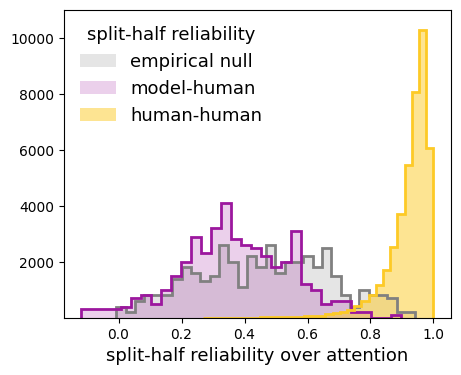

In [ ]:
GAZE_COLORS =  mpl.colormaps['plasma'](np.linspace(0, 1, 10))


plt.figure(figsize=[5,4])

empirical_null = np.mean(split_half_gaze['r_human_null'])
empirical_ceiling = np.median( split_half_gaze['r_splithalf'])
i_layer = split_half_gaze['r_model_transp'][i]

nbins = 32
plt.hist( split_half_gaze['r_human_null'], color='grey', alpha=1, bins=nbins, histtype='step', linewidth=2)
plt.hist( split_half_gaze['r_human_null'], color='grey', alpha=.2, bins=nbins, label='empirical null')

plt.hist( i_layer, alpha=.2, bins=nbins, color=GAZE_COLORS[3], label='model-human')
plt.hist( i_layer, alpha=1, bins=nbins, color=GAZE_COLORS[3], histtype='step', linewidth=2)

plt.hist( split_half_gaze['r_splithalf'], color=GAZE_COLORS[-2], alpha=.5, bins=nbins, label='human-human')
plt.hist( split_half_gaze['r_splithalf'], color=GAZE_COLORS[-2], alpha=1, bins=nbins, histtype='step', linewidth=2)
plt.legend(title='split-half reliability', frameon=0, title_fontsize=13, fontsize=13)
plt.xlabel('split-half reliability over attention', fontsize=13);
plt.ylim(1, 11020)
if figure_save_location:
  path = os.path.join(figure_save_location, 'reliability_attention_human_model.pdf')
  plt.savefig(path, bbox_inches='tight');

## scatterplot of (binned) human reaction time by model performance

In [1]:
model_names = {'dino': 'dinov2-giant',
               'clip': 'CLIP_ViT-g'}

model_name = model_names['dino'] # 'dinov2-giant_svm_avg'

plt.figure(figsize=[15,3])

mname = '%s_svm_avg'%model_name
for iplot, d in enumerate(df.dataset.unique()):

  plt.subplot(1,4,iplot+1)
  if not iplot: plt.ylabel('Human Performance', fontsize=12);

  idf = df[df.dataset==d]
  idf['trial_group'] = sort_trials(idf, n_groups=50)

  y= idf.groupby('trial_group').human_accuracy.mean()
  x = idf.groupby('trial_group')[mname].mean()

  r = np.corrcoef(x, y)[0,1]
  xerr = idf.groupby('trial_group')['%s_svm_sem'%model_name].mean()
  yerr = idf.groupby('trial_group').human_accuracy_sem.mean()

  plt.scatter(x, y,linewidth=.7, color=colors[d], edgecolor='black', label='r=%.02f'%r)
  plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', zorder=-2, color=colors[d], alpha=.5)

  plt.xlabel('DINOv2 Performance', fontsize=12)
  plt.plot([-.36, 1], [-.36, 1], linestyle='--', color='grey', zorder=-1)
  plt.title(d)
  #plt.legend(loc=3, frameon=1)
  plt.ylim(-.41, 1.08)
  plt.xlim(-.41, 1.08)
if figure_save_location:
  print('!')
  path = os.path.join(figure_save_location, 'human_and_model_accuracy_binned_scatterplot_perhumanaccuracy.pdf')
  plt.savefig(path, bbox_inches='tight');

NameError: name 'plt' is not defined

# supplemental figures

## scatterplot of trial level human v model performance

r$_{spearman}$ = 0.40


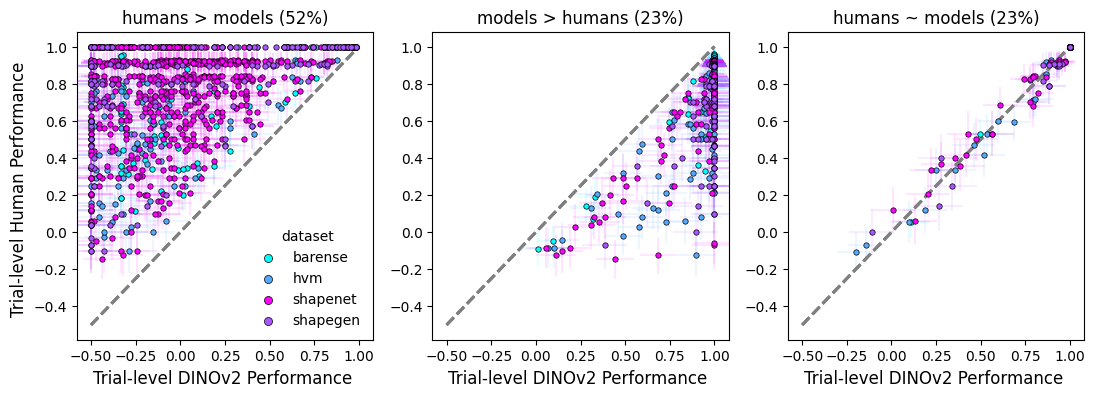

In [ ]:
def single_plot(x,y,e,c,ylabel=False):

  #c = '#55B3B1'

  plt.scatter(x = x, y = y, s=15, color=c,edgecolor='black', linewidth=.5, label=i_dataset)

  plt.errorbar(x, y, yerr=e, xerr=e,
              ls='', color=c, alpha=.1, zorder=-10, )
  plt.plot([-.5, 1], [-.5, 1],
           linestyle='--', color='grey', zorder=-10, linewidth=2)
  plt.xlim(-.58, 1.08)
  plt.ylim(-.58, 1.08)

  plt.xlabel('Trial-level DINOv2 Performance ', fontsize=12)
  if ylabel:
    plt.ylabel('Trial-level Human Performance ', fontsize=12)
    plt.legend( markerscale=1.5, loc=4, title='dataset', frameon=0)

xlabel = 'dino_linear_avg'
ylabel = 'human_accuracy'
elabel = 'human_accuracy_sem'
xlabel = 'dinov2-giant_svm_avg'
xerr = 'dinov2-giant_svm_sem'

y = df[ylabel].values
x = df[xlabel].values
e = df[elabel].values

print( r'r$_{spearman}$ = %.02f'%stats.spearmanr(x, y)[0] )

human_over_model = sum(y - x > e)
model_over_human = sum(x - y > e)
human_with_model = sum(np.abs(x - y) <= (e))
total = human_over_model + model_over_human + human_with_model

plt.figure(figsize=[13, 4])

for i_dataset in df.dataset.unique():

  df_subset = df[df.dataset==i_dataset]
  x = df_subset[xlabel].values
  y = df_subset[ylabel].values
  error = df_subset[elabel].values
  c = colors[i_dataset]

  xmin = np.min(x) - .2
  xmax = np.max(x) + .2

  plt.subplot(131)
  plt.title("humans > models (%d%%)"%(100 * human_over_model/total))
  idf = df_subset[(y - x) > error]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c, ylabel=1)

  plt.subplot(132)
  plt.title("models > humans (%d%%)"%(100 * model_over_human/total))
  idf = df_subset[(x - y)>error]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c)

  plt.subplot(133)
  plt.title("humans ~ models (%d%%)"%(100 * human_with_model/total))
  idf = df_subset[np.abs(x - y)  <= (error)]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c)

if figure_save_location:
  path = os.path.join(figure_save_location, 'dino_v_human_triallevel.pdf')
  plt.savefig(path, bbox_inches='tight');

## visualize weighted linear readout performance alongside different distance metrics

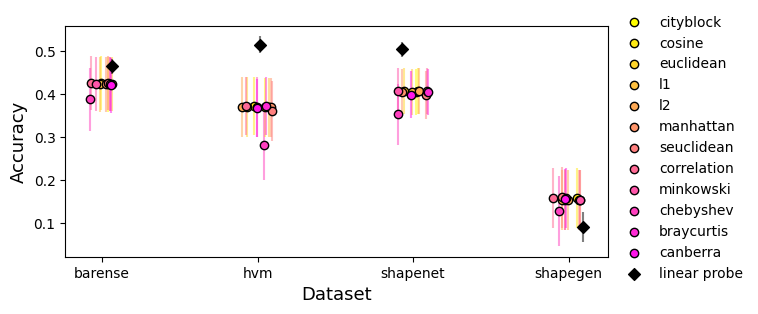

In [ ]:
dmetrics = [i for i in df_distance.columns if ('avg' in i)*('svm' not in i)]

df_distance['dino_svm_avg'] = df['dinov2-base_svm_avg']
df_distance['dino_svm_sem'] = df['dinov2-base_svm_sem']
plt.figure(figsize=[7,3])

distances = [c for c in df_distance.columns if ('avg' in c)*('distance' not in c)]
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
n_colors = len(distances)
cmap = mpl.colormaps['spring'] # cool, spring, bwr
distance_colors = cmap(np.linspace(0, 1, n_colors))[::-1]

corder = ['familiar_lowsim', 'abstract_lowsim', 'familiar_hisim', 'abstract_hisim',
          'animals', 'chairs', 'planes', 'faces',
          #'loudspeaker', 'bench',
          #'airplane', 'sofa', 'display', 'watercraft', 'car', 'cabinet',
          #'table', 'chair', 'telephone','lamp',
          'lamp_telephone_chair', 'bench_sofa_table', 'loudspeaker_display_cabinet', 'car_watercraft_airplane',
          'abstract4', 'abstract3', 'abstract2_abstract1', 'abstract0', ]

# Amount of jitter (adjust as needed)
jitter_amount = 0.1

x_offsets = np.random.uniform(-jitter_amount, jitter_amount, len(df.dataset.unique()))
for idx, c in enumerate(distances):

  means = df_distance.groupby('dataset')[c].mean().values
  sems = df_distance.groupby('dataset')[c[:-3]+'sem'].mean().values
  jitter_amount = 0.1
  x_offsets = np.random.uniform(-jitter_amount, jitter_amount, len(means))

  icolor = distance_colors[idx]
  marker = 'o'
  l = c.split('_')[1]
  if 'svm' in c:
    icolor = 'black'
    marker = 'D'
    l = 'linear probe'
  plt.scatter(range(len(means)) + x_offsets, means, label=l,
              color=icolor, marker=marker, edgecolor='black')
  plt.errorbar(range(len(means)) + x_offsets, means, yerr=sems, color=icolor,
               alpha=.5, zorder=-2, ls='')
plt.legend(bbox_to_anchor=[1,1.1], framealpha=0)
plt.xticks(range(len(df_distance.dataset.unique() )),
           df_distance.dataset.unique()) ;
plt.ylabel('Accuracy', fontsize=13)
plt.xlabel('Dataset', fontsize=13)

if figure_save_location:

  path = os.path.join(figure_save_location, 'comparing_distance_metrics.pdf')

  plt.savefig(path, bbox_inches='tight');

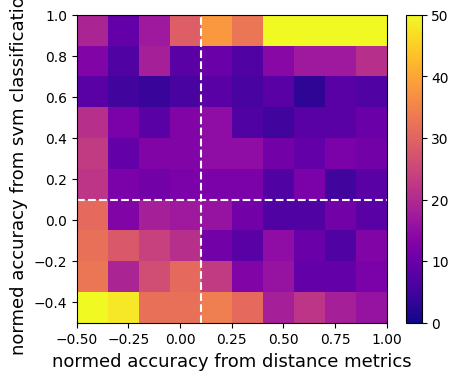

In [ ]:
plt.figure(figsize=[5,4])
plt.hist2d(df_distance['dino_distance_avg'],
         df_distance['dino_svm_avg'],
         cmap='plasma', clim=[0, 50])
plt.colorbar()
plt.xlabel('normed accuracy from distance metrics', fontsize=13)
plt.ylabel('normed accuracy from svm classification', fontsize=13)
plt.plot([-.5, 1], [.1, .1], linestyle='--', color='white')
plt.plot([.1, .1], [-.5, 1], linestyle='--', color='white')
if figure_save_location:
  path = os.path.join(figure_save_location, 'comparing_distance_metrics_2Dhist.pdf')
  plt.savefig(path, bbox_inches='tight');

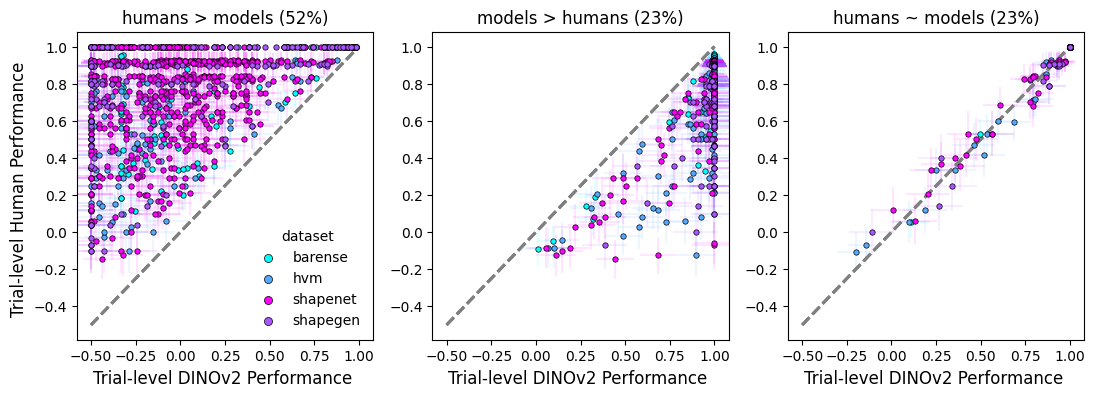

In [ ]:
def single_plot(x,y,e,c,ylabel=False):

  #c = '#55B3B1'

  plt.scatter(x = x, y = y, s=15, color=c,edgecolor='black', linewidth=.5, label=i_dataset)

  plt.errorbar(x, y, yerr=e, xerr=e,
              ls='', color=c, alpha=.1, zorder=-10, )
  plt.plot([-.5, 1], [-.5, 1],
           linestyle='--', color='grey', zorder=-10, linewidth=2)
  plt.xlim(-.58, 1.08)
  plt.ylim(-.58, 1.08)

  plt.xlabel('Trial-level DINOv2 Performance ', fontsize=12)
  if ylabel:
    plt.ylabel('Trial-level Human Performance ', fontsize=12)
    plt.legend( markerscale=1.5, loc=4, title='dataset', frameon=0)

xlabel = 'dino_linear_avg'
ylabel = 'human_accuracy'
elabel = 'human_accuracy_sem'
xlabel = 'dinov2-giant_svm_avg'
xerr = 'dinov2-giant_svm_sem'

y = df[ylabel].values
x = df[xlabel].values
e = df[elabel].values

human_over_model = sum(y - x > e)
model_over_human = sum(x - y > e)
human_with_model = sum(np.abs(x - y) <= (e))
total = human_over_model + model_over_human + human_with_model

plt.figure(figsize=[13, 4])

for i_dataset in df.dataset.unique():

  df_subset = df[df.dataset==i_dataset]
  x = df_subset[xlabel].values
  y = df_subset[ylabel].values
  error = df_subset[elabel].values
  c = colors[i_dataset]

  xmin = np.min(x) - .2
  xmax = np.max(x) + .2

  plt.subplot(131)
  plt.title("humans > models (%d%%)"%(100 * human_over_model/total))
  idf = df_subset[(y - x) > error]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c, ylabel=1)

  plt.subplot(132)
  plt.title("models > humans (%d%%)"%(100 * model_over_human/total))
  idf = df_subset[(x - y)>error]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c)

  plt.subplot(133)
  plt.title("humans ~ models (%d%%)"%(100 * human_with_model/total))
  idf = df_subset[np.abs(x - y)  <= (error)]
  single_plot(idf[xlabel], idf[ylabel],idf[elabel], c)

if figure_save_location:
  path = os.path.join(figure_save_location, 'dino_v_human_triallevel.pdf')
  plt.savefig(path, bbox_inches='tight');

## plot the binned, rank sorted human and model performance

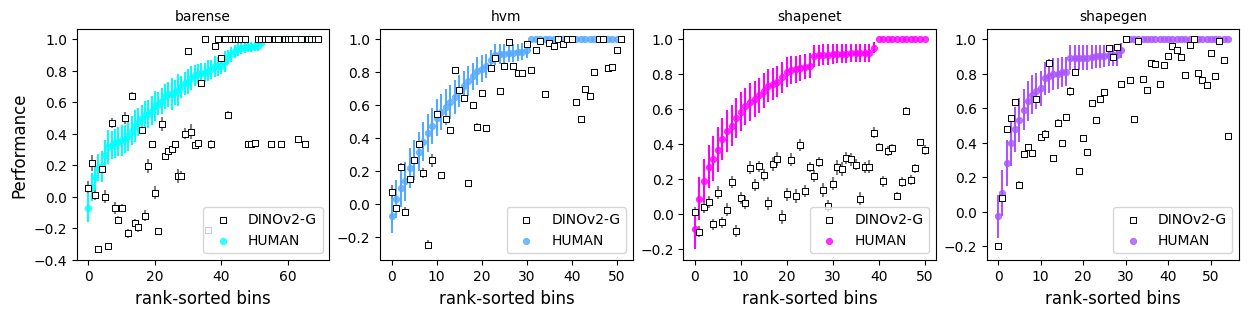

In [ ]:
model_names = {'dino': 'dinov2-giant',
               'clip': 'CLIP_ViT-g'}

model_name = model_names['dino'] # 'dinov2-giant_svm_avg'

plt.figure(figsize=[15,3])

mname = '%s_svm_avg'%model_name

for iplot, d in enumerate(df.dataset.unique()):

  plt.subplot(1,4,iplot+1)
  if not iplot: plt.ylabel('Performance', fontsize=12);

  idf = df[df.dataset==d]
  idf['trial_group'] = sort_trials(idf, n_groups=50)

  y= idf.groupby('trial_group').human_accuracy.mean()
  x = idf.groupby('trial_group')[mname].mean()

  r = np.corrcoef(x, y)[0,1]
  xerr = idf.groupby('trial_group')['%s_svm_sem'%model_name].mean()
  yerr = idf.groupby('trial_group').human_accuracy_sem.mean()

  plt.scatter(range(len(x)), x, linewidth=.7, edgecolor='black', zorder=2, facecolor='white', s=15, label='DINOv2-G', marker=',')
  plt.errorbar(range(len(x)), x, yerr=xerr, ls='', zorder=-2, color='black', alpha=.5)

  plt.scatter(range(len(x)), y, linewidth=.7, color=colors[d], edgecolor=colors[d], s=20, alpha=.8, label='HUMAN')
  plt.errorbar(range(len(x)), y, yerr=yerr, ls='', zorder=-2, color=colors[d], alpha=1)

  plt.xlabel('rank-sorted bins', fontsize=12)
  plt.title('%s'%(d), fontsize=10)
  plt.legend(loc=4, frameon=1) # title= 'r$_{spearman}$ = %.02f'%stats.pearsonr(x, y)[0],

if figure_save_location:
  print('!')
  path = os.path.join(figure_save_location, 'human_and_model_accuracy_sorted_binned_scatterplot_perhumanaccuracy.pdf')
  plt.savefig(path, bbox_inches='tight');

## show relationship between human reaction time and model performance

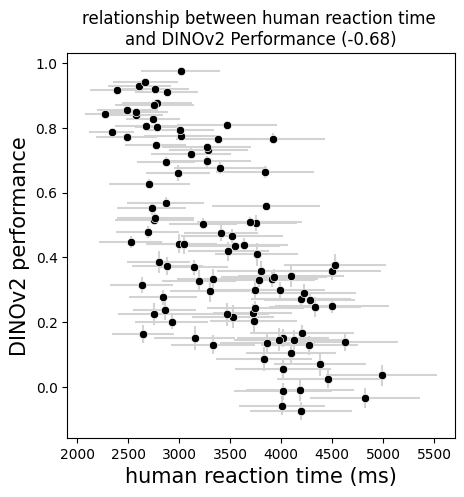

In [ ]:
plt.figure(figsize=[5,5])
sorted_indices = df.sort_values('human_accuracy').index
_size = 20
_markers = np.array([[j for i in range(_size)] for j in range(len(sorted_indices)//_size + 1)]).flatten()
_markers = _markers[:len(df)]
df['trial_group'] = [_markers[ np.nonzero(i == sorted_indices)[0][0]] for i in df.index.values]

model_name = 'dinov2-giant'

x = df.groupby('trial_group').human_rt.mean()
y = df.groupby('trial_group')['%s_svm_avg'%model_name].mean()
yerr = df.groupby('trial_group')['%s_svm_sem'%model_name].mean()
xerr = df.groupby('trial_group').human_rt_sem.mean()
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', color='lightgrey', zorder=-2)
plt.scatter(x, y,  color='black', edgecolor='white', linewidth=.5)

plt.title('relationship between human reaction time \nand DINOv2 Performance (%.02f)'%np.corrcoef(x, y)[0, 1])
plt.xlabel('human reaction time (ms)', fontsize=15)
plt.ylabel('DINOv2 performance', fontsize=15);

## barplots comparing human to model performance across conditions

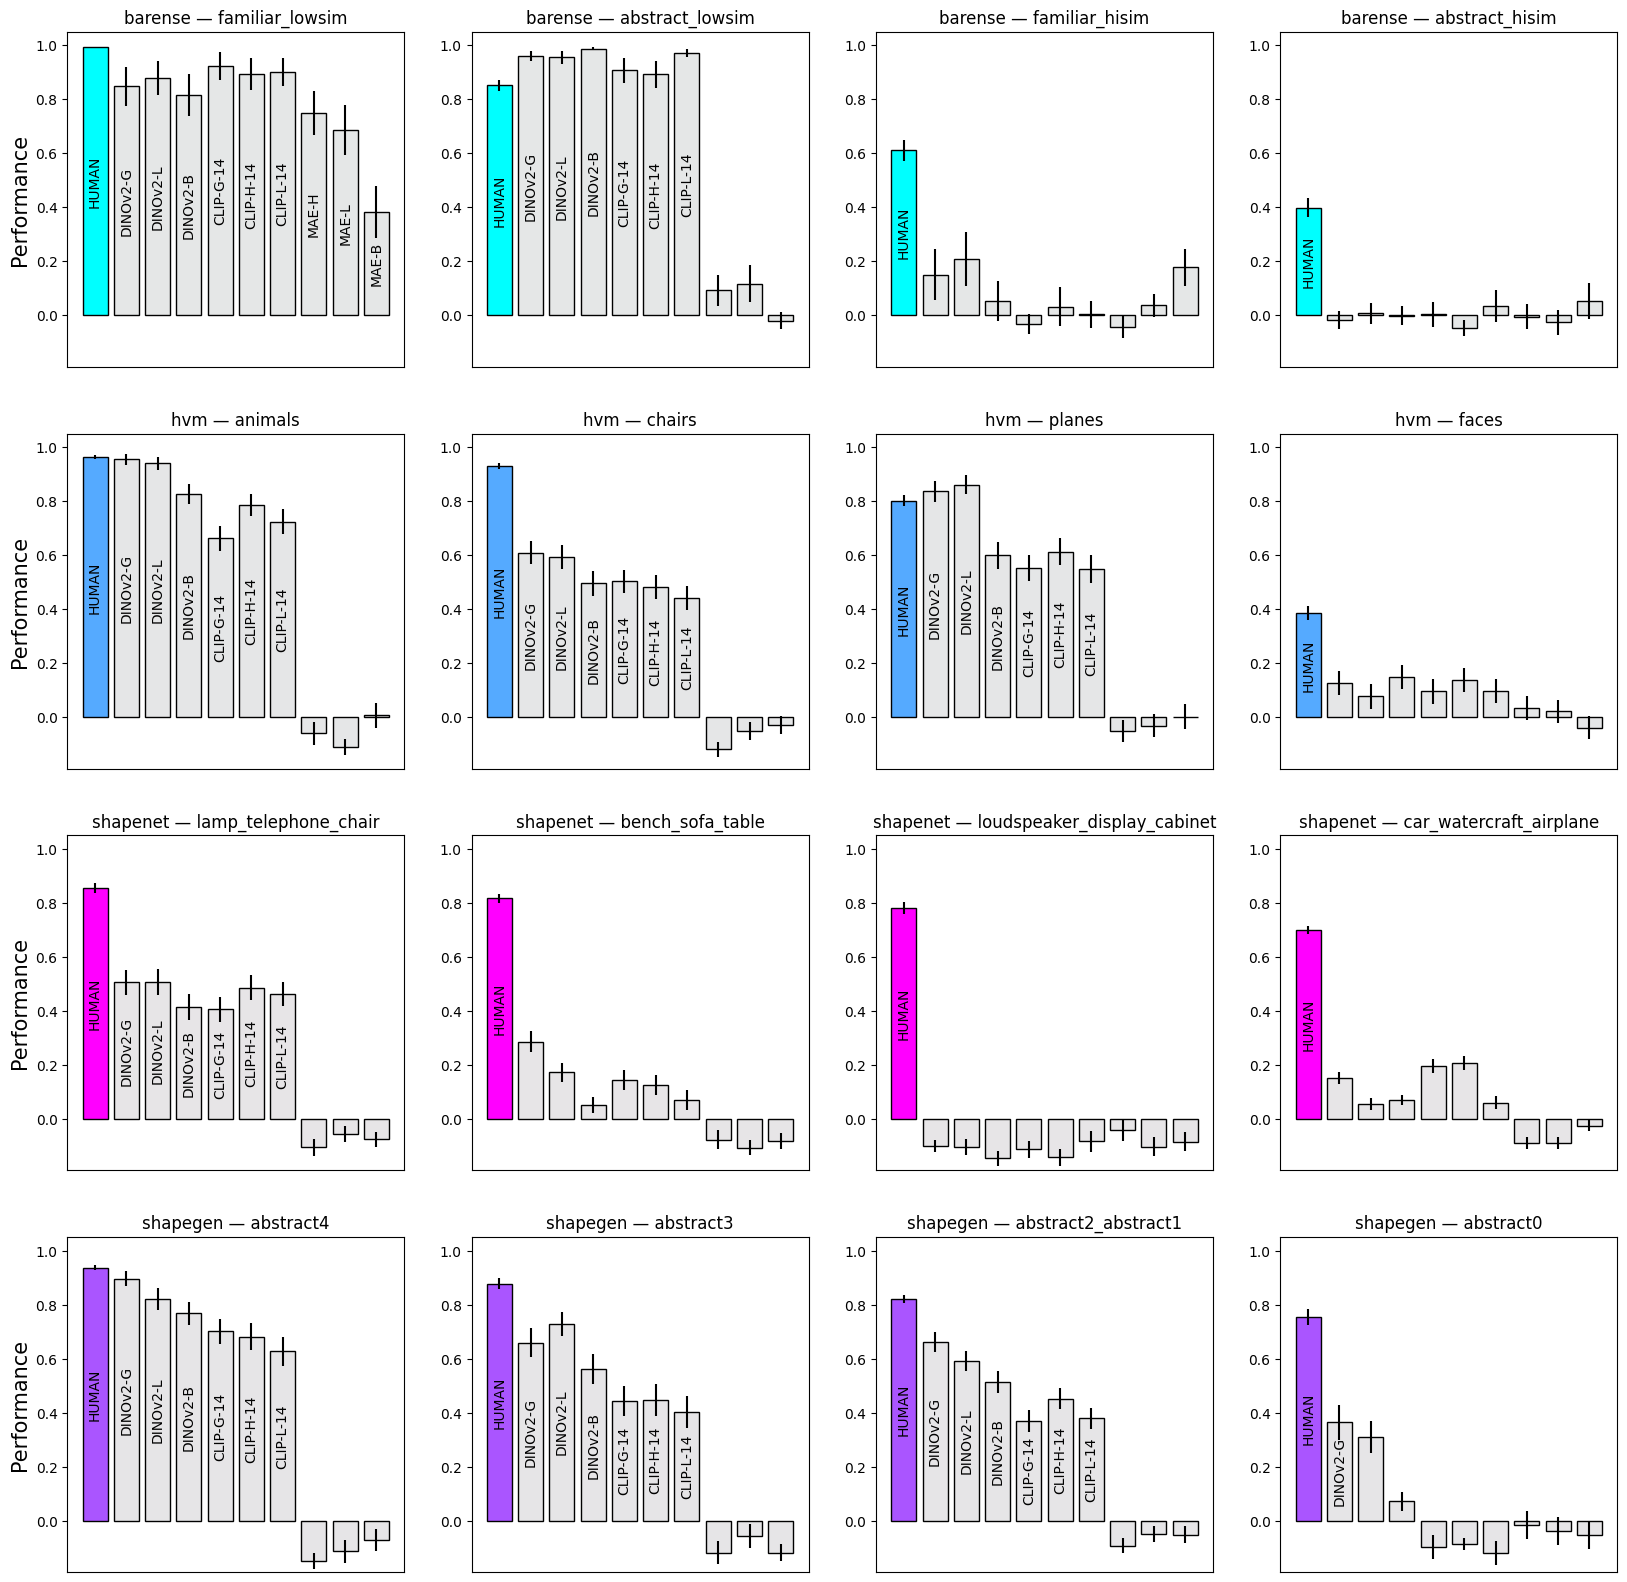

In [ ]:
corder = ['familiar_lowsim', 'abstract_lowsim', 'familiar_hisim',
          'abstract_hisim', 'animals', 'chairs', 'planes', 'faces',
          'lamp_telephone_chair', 'bench_sofa_table',
          'loudspeaker_display_cabinet', 'car_watercraft_airplane',
          'abstract4', 'abstract3', 'abstract2_abstract1', 'abstract0', ]

plt.figure(figsize=[20,20])

for iplot, condition in enumerate(corder):

  idf = df[[c in condition for c in df.condition]]
  d = idf.dataset.values[0]

  plt.subplot(4,4,iplot+1)

  pltbar = plt.bar(bars, idf[bars].mean() ,
          color=[[colors[d]* (.1, .1, .1, .1), colors[d]]['human' in i] for i in bars],
          edgecolor='black')
  plt.errorbar(bars, idf[bars].mean(),
              yerr=idf[bars].sem(), ls='', color='black')

  plt.xticks([], []) #rotation=90);
  plt.title('%s — %s'%(d, condition))
  plt.ylim(-.19, 1.05)
  if iplot%4==0:
    plt.ylabel('Performance', fontsize=15)

  if iplot ==0:
    # Apply bar_label to the entire BarContainer pltbar, not individual bars
    plt.bar_label(pltbar,
                    labels=[namekey[i] for i in bars], # Get labels for all bars
                    label_type='center', color='black', rotation=90)
    plt.ylabel('Performance', fontsize=15)

  else:
    plt.bar_label(
        pltbar,
         [[namekey[bars[i]], ''][pltbar[i].get_height()<.36] for i in range(len(bars))],
        label_type='center',color='black', rotation=90)

if figure_save_location:
  path = os.path.join(figure_save_location, 'human_and_model_boxplots_across_conditions.pdf')
  plt.savefig(path, bbox_inches='tight');